In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

In [7]:
# Common parameters
time = 1000
delta_t = 0.01

# Synaptic parameters
tau_c_INH = 4
tau_o_INH = 1.5
delta_INH = 3
E_INH = -75

tau_c_AMPA = 3
tau_o_AMPA = 0.2
delta_AMPA = 1.25
E_AMPA = 0

tau_c_NMDA = 80
tau_o_NMDA = 0.5
delta_NMDA = 1.25
E_NMDA = 0

tau_c_GABA = 1.5
tau_o_GABA = 70
delta_GABA = 3
E_GABA = -70

In [8]:
# Initialise variables for dIN population

din_c_m = 10
g_gj = 0.2
din_m = 0.0529
din_h = 0.5961
din_nf = 0.3177
din_ns = 0.3177
r = 0.00346
din_g_L = 2.5
din_g_Kf = 250
din_g_Na = 3000
din_g_Ks = 200
din_E_L = -52
din_E_Na = 50
din_E_K = -81.5

p_Ca = 14.25 #142.5
F = 96485
R = 8.314
T = 300
S_in = 10**(-7)
S_out = 10**(-5)

# A, B, C ,D, E
# Ca
ar_A = 4
ar_B = 0
ar_C = 1
ar_D = -15.3
ar_E = -13.6
br_Aa = 1.2
br_Ba = 0
br_Ca = 1
br_Da = 10.6
br_Ea = 1
br_Ab = 1.3
br_Bb = 0
br_Cb = 1
br_Db = 5.4
br_Eb = 12.1
# Kf
din_Kf_a_A = 5.1 
din_Kf_a_B = 0.1 
din_Kf_a_C = 20#5.1#20
din_Kf_a_D = -20#-18.4#-20 
din_Kf_a_E = 23#-25.4
din_Kf_b_A = 0.5 
din_Kf_b_B = 0
din_Kf_b_C = 0
din_Kf_b_D = 28.7 
din_Kf_b_E = 34.6 
# Ks
din_Ks_a_A = 0.5
din_Ks_a_B = 8.2e-3
din_Ks_a_C = 20#4.6
din_Ks_a_D = -4.2
din_Ks_a_E = -12
din_Ks_b_A = 0.1
din_Ks_b_B = -1.3e-3
din_Ks_b_C = 1.6
din_Ks_b_D = 2.1e5
din_Ks_b_E = 3.3e5
# Na
din_am_A = 8.7
din_am_B = 0
din_am_C = 1
din_am_D = -1
din_am_E = -5#12.6
din_bm_A = 3.8
din_bm_B = 0
din_bm_C = 1
din_bm_D = 9
din_bm_E = -10 #9.7
din_ah_A = 0.1
din_ah_B = 0
din_ah_C = 0
din_ah_D = 38.9
din_ah_E = 26
din_bh_A = 4.1
din_bh_B = 0
din_bh_C = 1
din_bh_D = -5.1
din_bh_E = -10.2

In [9]:
# Set up vectors/matrices to store and update variables for dINs
# 16 each side so 32 total
n_dins = 32

# Gating vector: size = number of dINs x number of gating variables. row 1 = m; 2 = h; 3 = nf; 4 = ns; 5 = r
n_gating_variables = 5
din_gating_vec = np.zeros((n_dins,n_gating_variables))
din_gating_vec[:,0] += din_m
din_gating_vec[:,1] += din_h
din_gating_vec[:,2] += din_nf
din_gating_vec[:,3] += din_ns
din_gating_vec[:,4] += r

# Voltage vector: size = number of dINs x 1; stored voltage matrix: size = number of recorded neurons x number of time steps 
n_record = 2
n_timesteps = len(np.arange(0,time,delta_t))
din_voltage_vec = np.zeros((n_dins,1))
din_voltage_vec[:,:] += din_E_L
din_voltage_record = np.zeros((n_record,n_timesteps))

# Spike times list of lists: number of lists = number of dINs 
din_spike_times = [[] for n in range(n_dins)]

# Gap junctions matrix: size = number of dINs x number of dINs. Each dIN makes gap junction with neighbouring 3 below and 3 above its index. No self-connections.
gap_junctions = np.zeros((n_dins,n_dins))
for r in range(n_dins):
    for c in range(n_dins):
        if r < n_dins/2 and c < n_dins/2 or r >= n_dins/2 and c >= n_dins/2:
            if abs(r-c) < 4 and r != c:
                gap_junctions[r,c] += 1

# Synaptic connections matrix within dIN population: size = number of dINs x number of dINs. Connection probability = 0.08. No self-connections.
din_synapses = np.zeros((n_dins,n_dins))
for r in range(n_dins):
    for c in range(n_dins):
        if r < n_dins/2 and c < n_dins/2 or r >= n_dins/2 and c >= n_dins/2:
            if random.random() < 0.1:
                din_synapses[r,c] += 1

In [10]:
# Initialise variables for MN/aIN/cIN population 
mn_c_m = 10

mn_m = 0.0529
mn_h = 0.5961
mn_nf = 0.3177
mn_ns = 0.3177

mn_g_L = 2.5
mn_g_Kf = 80
mn_g_Na = 1100
mn_g_Ks = 10
mn_E_L = -52
mn_E_Na = 50
mn_E_K = -81.5

# A, B, C ,D, E

# Kf
mn_Kf_a_A = 3.1
mn_Kf_a_B = 0
mn_Kf_a_C = 1
mn_Kf_a_D = -27.5
mn_Kf_a_E = -9.3
mn_Kf_b_A = 0.4
mn_Kf_b_B = 0
mn_Kf_b_C = 1
mn_Kf_b_D = 9
mn_Kf_b_E = 16.2
# Ks
mn_Ks_a_A = 0.2
mn_Ks_a_B = 0
mn_Ks_a_C = 1
mn_Ks_a_D = -3
mn_Ks_a_E = -7.7
mn_Ks_b_A = 0.05
mn_Ks_b_B = 0
mn_Ks_b_C = 1
mn_Ks_b_D = -14.1
mn_Ks_b_E = 6.1
# Na
mn_am_A = 13.3
mn_am_B = 0
mn_am_C = 0.5
mn_am_D = -5
mn_am_E = -12.6
mn_bm_A = 5.7
mn_bm_B = 0
mn_bm_C = 1
mn_bm_D = 5
mn_bm_E = 9.7
mn_ah_A = 0.04
mn_ah_B = 0
mn_ah_C = 0
mn_ah_D = 28.8
mn_ah_E = 40#26
mn_bh_A = 2
mn_bh_B = 0
mn_bh_C = 0
mn_bh_D = -9.1
mn_bh_E = -10.2


In [11]:
# Set up vectors/matrices to store and update variables for MNs/aINs/cINs/dlas/dlcs
# 25 (248 in model) MNs on one side so 50 total; 16 total aINs; 54 total cINs; 6 dlas; 21 dlcs
n_mns = 50
n_ains = 16
n_cins = 54

# Gating vector: size = number of MNs x number of gating variables. row 1 = m; 2 = h; 3 = nf; 4 = ns.
n_gating_variables = 4
mn_gating_vec = np.zeros((n_mns,n_gating_variables))
mn_gating_vec[:,0] += mn_m
mn_gating_vec[:,1] += mn_h
mn_gating_vec[:,2] += mn_nf
mn_gating_vec[:,3] += mn_ns
# Same for aINs/cINs/dlas/dlcs
ain_gating_vec = np.zeros((n_ains,n_gating_variables))
ain_gating_vec[:,0] += mn_m
ain_gating_vec[:,1] += mn_h
ain_gating_vec[:,2] += mn_nf
ain_gating_vec[:,3] += mn_ns
cin_gating_vec = np.zeros((n_cins,n_gating_variables))
cin_gating_vec[:,0] += mn_m
cin_gating_vec[:,1] += mn_h
cin_gating_vec[:,2] += mn_nf
cin_gating_vec[:,3] += mn_ns

# Voltage vector: size = number of MNs x 1; stored voltage matrix: size = number of recorded neurons x number of time steps. 
n_record = 2
n_timesteps = len(np.arange(0,time,delta_t))
mn_voltage_vec = np.zeros((n_mns,1))
mn_voltage_vec[:,:] += mn_E_L
mn_voltage_record = np.zeros((n_record,n_timesteps))
# Same for aINs/cINs/dlas/dlcs
ain_voltage_vec = np.zeros((n_ains,1))
ain_voltage_vec[:,:] += mn_E_L
ain_voltage_record = np.zeros((n_record,n_timesteps))
cin_voltage_vec = np.zeros((n_cins,1))
cin_voltage_vec[:,:] += mn_E_L
cin_voltage_record = np.zeros((n_record,n_timesteps))

# Spike times list of lists: number of lists = number of MNs. 
mn_spike_times = [[] for m in range(n_mns)]

# Same for aINs/cINs/dlas/dlcs
ain_spike_times = [[] for m in range(n_ains)]
cin_spike_times = [[] for m in range(n_cins)]

# aIN -> aIN connections
ain_synapses = np.zeros((n_ains,n_ains))
for r in range(n_ains):
    for c in range(n_ains):
        if r < n_ains/2 and c < n_ains/2 or r >= n_ains/2 and c >= n_ains/2:
            if random.random() < 0.1:
                ain_synapses[r,c] += 1

In [12]:
# Synaptic connections from dIN -> MN population; aIN -> aIN/dIN/cIN

# Synaptic connections matrix dIN -> MN: size = number of dINs (presynaptic neurons) x number of MNs (postsynaptic neurons). Connection probability = 0.8.
din_mn_synapses = np.zeros((n_dins,n_mns))
for r in range(n_dins):
    for c in range(n_mns):
        if r < n_dins/2 and c < n_mns/2 or r >= n_dins/2 and c >= n_mns/2:
            if random.random() < 1:
                din_mn_synapses[r,c] += 0.1
            
# dIN -> aIN. Connection probability = 0.8.
din_ain_synapses = np.zeros((n_dins,n_ains))
for r in range(n_dins):
    for c in range(n_ains):
        if r < n_dins/2 and c < n_ains/2 or r >= n_dins/2 and c >= n_ains/2:
            if random.random() < 1:
                din_ain_synapses[r,c] += 0.1
                
# dIN -> cIN. Connection probability = 0.8.
din_cin_synapses = np.zeros((n_dins,n_cins))
for r in range(n_dins):
    for c in range(n_cins):
        if r < n_dins/2 and c < n_cins/2 or r >= n_dins/2 and c >= n_cins/2:
            if random.random() < 1:
                din_cin_synapses[r,c] += 0.1    
                
# aIN -> MN. Connection probability = 0.8.
ain_mn_synapses = np.zeros((n_ains,n_mns))
for r in range(n_ains):
    for c in range(n_mns):
        if r < n_ains/2 and c < n_mns/2 or r >= n_ains/2 and c >= n_mns/2:
            if random.random() < 1:
                ain_mn_synapses[r,c] += 0.1 
            
# aIN -> dIN synapses. Connection probability 0.8.
ain_din_synapses = np.zeros((n_ains,n_dins))
for r in range(n_ains):
    for c in range(n_dins):
        if r < n_ains/2 and c < n_dins/2 or r >= n_ains/2 and c >= n_dins/2:
            if random.random() < 1:
                ain_din_synapses[r,c] += 0.1  
                
# aIN -> cIN synapses. Connection probability 0.8.
ain_cin_synapses = np.zeros((n_ains,n_cins))
for r in range(n_ains):
    for c in range(n_cins):
        if r < n_ains/2 and c < n_cins/2 or r >= n_ains/2 and c >= n_cins/2:
            if random.random() < 1:
                ain_cin_synapses[r,c] += 0.1  
                
# cIN -> aIN synapses. Connection probability 0.8.
cin_ain_synapses = np.zeros((n_cins,n_ains))
for r in range(n_cins):
    for c in range(n_ains):
        if r < n_cins/2 and c >= n_ains/2 or r >= n_cins/2 and c < n_ains/2:
            if random.random() < 1:
                cin_ain_synapses[r,c] += 0.1 
            
# cIN -> dIN synapses. Connection probability 0.8.
cin_din_synapses = np.zeros((n_cins,n_dins))
for r in range(n_cins):
    for c in range(n_dins):
        if r < n_cins/2 and c >= n_dins/2 or r >= n_cins/2 and c < n_dins/2:
            if random.random() < 1:
                cin_din_synapses[r,c] += 0.1 
            
# cIN -> MN synapses. Connection probability = 0.8.
cin_mn_synapses = np.zeros((n_cins,n_mns))
for r in range(n_cins):
    for c in range(n_mns):
        if r < n_cins/2 and c >= n_mns/2 or r >= n_cins/2 and c < n_mns/2:
            if random.random() < 1:
                cin_mn_synapses[r,c] += 0.1 
                
# cIN -> cIN synapses. Connection probability 0.8.
cin_synapses = np.zeros((n_cins,n_cins))
for r in range(n_cins):
    for c in range(n_cins):
        if r < n_cins/2 and c >= n_ains/2 or r >= n_cins/2 and c < n_ains/2:
            if random.random() < 1:
                cin_synapses[r,c] += 0.1
                
# MN -> dIN synapses.
mn_din_synapses = np.zeros((n_mns,n_dins))
for r in range(n_mns):
    for c in range(n_dins):
        if r < n_mns/2 and c < n_dins/2 or r >= n_mns/2 and c >= n_dins/2:
            if random.random() < 1:
                mn_din_synapses[r,c] += 0.1
                
# MN -> aIN synapses.
mn_ain_synapses = np.zeros((n_mns,n_ains))
for r in range(n_mns):
    for c in range(n_ains):
        if r < n_mns/2 and c < n_ains/2 or r >= n_mns/2 and c >= n_ains/2:
            if random.random() < 1:
                mn_ain_synapses[r,c] += 0.1
                
# MN -> cIN synapses.
mn_cin_synapses = np.zeros((n_mns,n_cins))
for r in range(n_mns):
    for c in range(n_cins):
        if r < n_mns/2 and c < n_cins/2 or r >= n_mns/2 and c >= n_cins/2:
            if random.random() < 1:
                mn_cin_synapses[r,c] += 0.1    
                
# MN -> MN synapses.
mn_synapses = np.zeros((n_mns,n_mns))
for r in range(n_mns):
    for c in range(n_mns):
        if r < n_mns/2 and c < n_mns/2 or r >= n_mns/2 and c >= n_mns/2:
            if random.random() < 1 and r != c:
                mn_synapses[r,c] += 0.1

In [13]:
# Functions needed to update gating variables and depress NMDA synapses for dINs

def X_inf_tau_x(V,Aa,Ba,Ca,Da,Ea,Ab,Bb,Cb,Db,Eb):
    alpha = (Aa + Ba * V)/(Ca + np.exp((Da + V)/Ea))
    beta = (Ab + Bb * V)/(Cb + np.exp((Db + V)/Eb))
    x_inf = alpha/(alpha+beta)
    tau_x = 1/(alpha+beta)
    return x_inf, tau_x

def f_NMDA(V):
    f = (0-V)*(1+0.05*np.exp(-0.08*V))**(-1)
    return f

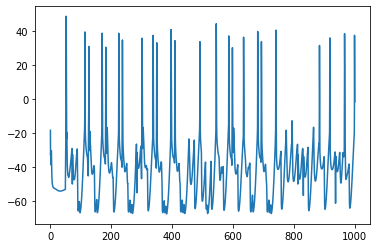

In [14]:
# Run network for specified amount of time

for idx, t in enumerate(np.arange(0,time,delta_t)):
    sum_spikes_NMDA_dIN = np.zeros((1,n_dins))
    sum_spikes_INH_aIN_dIN = np.zeros((1,n_dins))
    sum_spikes_INH_aIN_MN = np.zeros((1,n_mns))
    sum_spikes_INH_aIN = np.zeros((1,n_ains))
    sum_spikes_INH_aIN_cIN = np.zeros((1,n_cins))
    sum_spikes_AMPA_dIN = np.zeros((1,n_dins))
    sum_spikes_AMPA_dIN_MN = np.zeros((1,n_mns))
    sum_spikes_AMPA_dIN_aIN = np.zeros((1,n_ains))
    sum_spikes_AMPA_dIN_cIN = np.zeros((1,n_cins))
    sum_spikes_AMPA_MN_dIN = np.zeros((1,n_dins))
    sum_spikes_AMPA_MN_aIN = np.zeros((1,n_ains))
    sum_spikes_AMPA_MN_cIN = np.zeros((1,n_cins))
    sum_spikes_AMPA_MN = np.zeros((1,n_mns))
    sum_spikes_INH_cIN_aIN = np.zeros((1,n_ains))
    sum_spikes_INH_cIN_dIN = np.zeros((1,n_dins))
    sum_spikes_INH_cIN_MN = np.zeros((1,n_mns))
    sum_spikes_INH_cIN = np.zeros((1,n_cins))
    i_gj = np.zeros((1,n_dins))
    if t < 50:
        I_ext_L_dIN = 0
        I_ext_R_dIN = 0
        I_ext_L = 0
        I_ext_R = 0
    if t > 50 and t < 60:
        I_ext_L_dIN = 250
        I_ext_L = 80
        I_ext_R_dIN = 100
        I_ext_R = 80
    if t > 60:
        I_ext_L_dIN = 200
        I_ext_L = 80
        I_ext_R_dIN = 200
        I_ext_R = 80    
    # if t > 75:
    #     I_ext_L_dIN = 200
    #     I_ext_L = 50
    #     I_ext_R_dIN = 50
    #     I_ext_R = 50
    # dIN gap junctions
    for row in range(n_dins):
        for c in range(n_dins):
            i_gj[:,row] += gap_junctions[row,c]*(din_voltage_vec[row,-1] - din_voltage_vec[c,-1])*g_gj
    i_gj = i_gj.reshape(n_dins,1)
    # Synapses
    # dIN recurrent synapses
    for din in range(n_dins):
        spikes = din_spike_times[din]
        for spike in spikes:
            if spike + 1 < t:
                ct = np.exp((spike+1-t)/tau_c_NMDA)
                ot = np.exp((spike+1-t)/tau_o_NMDA)
                delta_NMDA = 1.25*(1-((ct - ot)/0.025))
                delta_NMDA = 1.25*(1-(ct - ot))
                sum_spikes_NMDA_dIN += din_synapses[din,:]*delta_NMDA*(ct - ot)
    # aIN -> dIN/MN/cIN/aIN synapses
    for ain in range(n_ains):
        spikes = ain_spike_times[ain]
        for spike in spikes:
            if spike + 1 < t:
                ain_ct = np.exp((spike+1-t)/tau_c_INH)
                ain_ot = np.exp((spike+1-t)/tau_o_INH)
                sum_spikes_INH_aIN_dIN += ain_din_synapses[ain,:]*delta_INH*(ain_ct - ain_ot)
                sum_spikes_INH_aIN_MN += ain_mn_synapses[ain,:]*delta_INH*(ain_ct - ain_ot)
                sum_spikes_INH_aIN += ain_synapses[ain,:]*delta_INH*(ain_ct - ain_ot)
                sum_spikes_INH_aIN_cIN += ain_cin_synapses[ain,:]*delta_INH*(ain_ct - ain_ot)
    # dIN to MN/aIN/cIN/dIN synapses
    for din in range(n_dins):
        spikes = din_spike_times[din]
        for spike in spikes:
            if spike + 1 < t:
                din_ct = np.exp((spike+1-t)/tau_c_AMPA)
                din_ot = np.exp((spike+1-t)/tau_o_AMPA)
                sum_spikes_AMPA_dIN_MN += din_mn_synapses[din,:]*delta_AMPA*(din_ct - din_ot)
                sum_spikes_AMPA_dIN_aIN += din_ain_synapses[din,:]*delta_AMPA*(din_ct - din_ot)
                sum_spikes_AMPA_dIN_cIN += din_cin_synapses[din,:]*delta_AMPA*(din_ct - din_ot)
                sum_spikes_AMPA_dIN += din_synapses[din,:]*delta_AMPA*(din_ct - din_ot)
    # cIN -> aIN/dIN/MN/cIN synapses
    for cin in range(n_cins):
        spikes = cin_spike_times[cin]
        for spike in spikes:
            if spike + 1 < t:
                cin_ct = np.exp((spike+1-t)/tau_c_INH)
                cin_ot = np.exp((spike+1-t)/tau_o_INH)
                sum_spikes_INH_cIN_aIN += cin_ain_synapses[cin,:]*delta_INH*(cin_ct - cin_ot)
                sum_spikes_INH_cIN_dIN += cin_din_synapses[cin,:]*delta_INH*(cin_ct - cin_ot)
                sum_spikes_INH_cIN_MN += cin_mn_synapses[cin,:]*delta_INH*(cin_ct - cin_ot)
                sum_spikes_INH_cIN += cin_synapses[cin,:]*delta_INH*(cin_ct - cin_ot)
    # MN -> CPG synapses
    for mn in range(n_mns):
        spikes = mn_spike_times[mn]
        for spike in spikes:
            if spike + 1 < t:
                mn_ct = np.exp((spike+1-t)/tau_c_AMPA)
                mn_ot = np.exp((spike+1-t)/tau_o_AMPA)
                sum_spikes_AMPA_MN_dIN += mn_din_synapses[mn,:]*delta_AMPA*(mn_ct - mn_ot)
                sum_spikes_AMPA_MN_aIN += mn_ain_synapses[mn,:]*delta_AMPA*(mn_ct - mn_ot)
                sum_spikes_AMPA_MN_cIN += mn_cin_synapses[mn,:]*delta_AMPA*(mn_ct - mn_ot)
                sum_spikes_AMPA_dIN_cIN += mn_cin_synapses[mn,:]*delta_AMPA*(mn_ct - mn_ot)
                sum_spikes_AMPA_MN += mn_synapses[mn,:]*delta_AMPA*(mn_ct - mn_ot)
    # Calculate value of each current for each neuron type
    i_syn_INH_dIN = 8 * (E_INH - din_voltage_vec) * sum_spikes_INH_aIN_dIN.T + 8 * (E_INH - din_voltage_vec) * sum_spikes_INH_cIN_dIN.T
    i_syn_INH_MN = 4 * (E_INH - mn_voltage_vec) * sum_spikes_INH_aIN_MN.T + 4 * (E_INH - mn_voltage_vec) * sum_spikes_INH_cIN_MN.T
    i_syn_INH_aIN = 4 * (E_INH - ain_voltage_vec) * sum_spikes_INH_aIN.T + 4 * (E_INH - ain_voltage_vec) * sum_spikes_INH_cIN_aIN.T
    i_syn_INH_cIN = 4 * (E_INH - cin_voltage_vec) * sum_spikes_INH_aIN_cIN.T + 4 * (E_INH - cin_voltage_vec) * sum_spikes_INH_cIN.T
    i_syn_AMPA_dIN = 12 * (E_AMPA - din_voltage_vec) * sum_spikes_AMPA_dIN.T + 12 * (E_AMPA - din_voltage_vec) * sum_spikes_AMPA_MN_dIN.T 
    i_syn_AMPA_MN = 6 * (E_AMPA - mn_voltage_vec) * sum_spikes_AMPA_dIN_MN.T + 6 * (E_AMPA - mn_voltage_vec) * sum_spikes_AMPA_MN.T 
    i_syn_AMPA_aIN = 1 * (E_AMPA - ain_voltage_vec) * sum_spikes_AMPA_dIN_aIN.T + 6 * (E_AMPA - ain_voltage_vec) * sum_spikes_AMPA_MN_aIN.T 
    i_syn_AMPA_cIN = 6 * (E_AMPA - cin_voltage_vec) * sum_spikes_AMPA_dIN_cIN.T + 6 * (E_AMPA - cin_voltage_vec) * sum_spikes_AMPA_MN_cIN.T
    i_syn_NMDA_dIN = 4 * f_NMDA(din_voltage_vec) * sum_spikes_NMDA_dIN.T
    # Add up different currents for each neuron type
    i_syn_dIN = i_syn_NMDA_dIN + i_syn_INH_dIN + i_syn_AMPA_dIN
    i_syn_MN = i_syn_AMPA_MN + i_syn_INH_MN 
    i_syn_aIN = i_syn_AMPA_aIN + i_syn_INH_aIN 
    i_syn_cIN = i_syn_AMPA_cIN + i_syn_INH_cIN
    # Calculate current and update variables for dINs
    x = (2*F*din_voltage_vec)/(R*T)*10**(-3)
    i_Ca = (r**2)*p_Ca*2*F*x*((S_in-S_out*np.exp(-x))/(1-np.exp(-x)))
    din_m = din_gating_vec[:,0].reshape(n_dins,1)
    din_h = din_gating_vec[:,1].reshape(n_dins,1)
    din_nf = din_gating_vec[:,2].reshape(n_dins,1)
    din_ns = din_gating_vec[:,3].reshape(n_dins,1)
    r = din_gating_vec[:,4].reshape(n_dins,1)
    din_i_m = din_g_L * (din_voltage_vec - din_E_L) + din_g_Kf * din_nf**4 * (din_voltage_vec - din_E_K) + din_g_Ks * din_ns**2 * (din_voltage_vec - din_E_K) \
              + din_g_Na * din_m**3 * din_h * (din_voltage_vec - din_E_Na) + i_Ca + i_gj - i_syn_dIN
    nf_inf, tau_nf = X_inf_tau_x(din_voltage_vec,din_Kf_a_A,din_Kf_a_B,din_Kf_a_C,din_Kf_a_D,din_Kf_a_E,din_Kf_b_A,din_Kf_b_B,din_Kf_b_C,din_Kf_b_D,din_Kf_b_E)
    ns_inf, tau_ns = X_inf_tau_x(din_voltage_vec,din_Ks_a_A,din_Ks_a_B,din_Ks_a_C,din_Ks_a_D,din_Ks_a_E,din_Ks_b_A,din_Ks_b_B,din_Ks_b_C,din_Ks_b_D,din_Ks_b_E) 
    m_inf, tau_m = X_inf_tau_x(din_voltage_vec,din_am_A,din_am_B,din_am_C,din_am_D,din_am_E,din_bm_A,din_bm_B,din_bm_C,din_bm_D,din_bm_E)
    h_inf, tau_h = X_inf_tau_x(din_voltage_vec,din_ah_A,din_ah_B,din_ah_C,din_ah_D,din_ah_E,din_bh_A,din_bh_B,din_bh_C,din_bh_D,din_bh_E)
    for din in range(n_dins):
        V = din_voltage_vec[din,-1]
        if V < -25:
            r_inf, tau_r = X_inf_tau_x(V,ar_A,ar_B,ar_C,ar_D,ar_E,br_Aa,br_Ba,br_Ca,br_Da,br_Ea)
        else:
            r_inf, tau_r = X_inf_tau_x(V,ar_A,ar_B,ar_C,ar_D,ar_E,br_Ab,br_Bb,br_Cb,br_Db,br_Eb)
        din_gating_vec[din,4] += delta_t*(r_inf - r[din]) / tau_r 
    din_gating_vec[:,0] += (delta_t*(m_inf - din_m) / tau_m).squeeze()
    din_gating_vec[:,1] += (delta_t*(h_inf - din_h) / tau_h).squeeze()
    din_gating_vec[:,2] += (delta_t*(nf_inf - din_nf) / tau_nf).squeeze()
    din_gating_vec[:,3] += (delta_t*(ns_inf - din_ns) / tau_ns).squeeze()
    din_new_V_L = (din_voltage_vec[:int(n_dins/2)] + delta_t*(-din_i_m[:int(n_dins/2)] + I_ext_L_dIN)/din_c_m).reshape(int(n_dins/2),1)
    din_new_V_R = (din_voltage_vec[int(n_dins/2):] + delta_t*(-din_i_m[int(n_dins/2):] + I_ext_R_dIN)/din_c_m).reshape(int(n_dins/2),1)                                                                  
    for din in range(n_dins):
        if din < n_dins/2:
            new_V = din_new_V_L[din,-1]
            old_V = din_voltage_vec[din,-1]
            if new_V > 20 and old_V < 20:
                din_spike_times[din].append(t)
        else:
            new_V = din_new_V_R[int(din-n_dins/2),-1]
            old_V = din_voltage_vec[din,-1]
            if new_V > 20 and old_V < 20:
                din_spike_times[din].append(t)
    din_voltage_vec = np.concatenate((din_new_V_L,din_new_V_R))
    din_voltage_record[:,idx] += din_voltage_vec[[0,int(n_dins/2)],:].squeeze()
    # Calculate current and update variables for aINs
    ain_m = ain_gating_vec[:,0].reshape(n_ains,1)
    ain_h = ain_gating_vec[:,1].reshape(n_ains,1)
    ain_nf = ain_gating_vec[:,2].reshape(n_ains,1)
    ain_ns = ain_gating_vec[:,3].reshape(n_ains,1)
    ain_i_m = mn_g_L * (ain_voltage_vec - mn_E_L) + mn_g_Kf * ain_nf**4 * (ain_voltage_vec - mn_E_K) + mn_g_Ks * ain_ns**2 * (ain_voltage_vec - mn_E_K) \
              + mn_g_Na * ain_m**3 * ain_h * (ain_voltage_vec - mn_E_Na) - i_syn_aIN
    nf_inf, tau_nf = X_inf_tau_x(ain_voltage_vec,mn_Kf_a_A,mn_Kf_a_B,mn_Kf_a_C,mn_Kf_a_D,mn_Kf_a_E,mn_Kf_b_A,mn_Kf_b_B,mn_Kf_b_C,mn_Kf_b_D,mn_Kf_b_E)
    ns_inf, tau_ns = X_inf_tau_x(ain_voltage_vec,mn_Ks_a_A,mn_Ks_a_B,mn_Ks_a_C,mn_Ks_a_D,mn_Ks_a_E,mn_Ks_b_A,mn_Ks_b_B,mn_Ks_b_C,mn_Ks_b_D,mn_Ks_b_E) 
    m_inf, tau_m = X_inf_tau_x(ain_voltage_vec,mn_am_A,mn_am_B,mn_am_C,mn_am_D,mn_am_E,mn_bm_A,mn_bm_B,mn_bm_C,mn_bm_D,mn_bm_E)
    h_inf, tau_h = X_inf_tau_x(ain_voltage_vec,mn_ah_A,mn_ah_B,mn_ah_C,mn_ah_D,mn_ah_E,mn_bh_A,mn_bh_B,mn_bh_C,mn_bh_D,mn_bh_E)
    ain_gating_vec[:,0] += (delta_t*(m_inf - ain_m) / tau_m).squeeze()
    ain_gating_vec[:,1] += (delta_t*(h_inf - ain_h) / tau_h).squeeze()
    ain_gating_vec[:,2] += (delta_t*(nf_inf - ain_nf) / tau_nf).squeeze()
    ain_gating_vec[:,3] += (delta_t*(ns_inf - ain_ns) / tau_ns).squeeze()
    ain_new_V_L = (ain_voltage_vec[:int(n_ains/2)] + delta_t*(-ain_i_m[:int(n_ains/2)] + I_ext_L)/mn_c_m).reshape(int(n_ains/2),1)
    ain_new_V_R = (ain_voltage_vec[int(n_ains/2):] + delta_t*(-ain_i_m[int(n_ains/2):] + I_ext_R)/mn_c_m).reshape(int(n_ains/2),1)
    for ain in range(n_ains):
        if ain < n_ains/2:
            new_V = ain_new_V_L[ain,-1]
            old_V = ain_voltage_vec[ain,-1]
            if new_V > 20 and old_V < 20:
                ain_spike_times[ain].append(t)
        else:
            new_V = ain_new_V_R[int(ain-n_ains/2),-1]
            old_V = ain_voltage_vec[ain,-1]
            if new_V > 20 and old_V < 20:
                ain_spike_times[ain].append(t)
    ain_voltage_vec = np.concatenate((ain_new_V_L,ain_new_V_R))
    ain_voltage_record[:,idx] += ain_voltage_vec[[0,int(n_ains/2)],:].squeeze()
    # Calculate current and update variables for cINs
    cin_m = cin_gating_vec[:,0].reshape(n_cins,1)
    cin_h = cin_gating_vec[:,1].reshape(n_cins,1)
    cin_nf = cin_gating_vec[:,2].reshape(n_cins,1)
    cin_ns = cin_gating_vec[:,3].reshape(n_cins,1)
    cin_i_m = mn_g_L * (cin_voltage_vec - mn_E_L) + mn_g_Kf * cin_nf**4 * (cin_voltage_vec - mn_E_K) + mn_g_Ks * cin_ns**2 * (cin_voltage_vec - mn_E_K) \
              + mn_g_Na * cin_m**3 * cin_h * (cin_voltage_vec - mn_E_Na) - i_syn_cIN
    nf_inf, tau_nf = X_inf_tau_x(cin_voltage_vec,mn_Kf_a_A,mn_Kf_a_B,mn_Kf_a_C,mn_Kf_a_D,mn_Kf_a_E,mn_Kf_b_A,mn_Kf_b_B,mn_Kf_b_C,mn_Kf_b_D,mn_Kf_b_E)
    ns_inf, tau_ns = X_inf_tau_x(cin_voltage_vec,mn_Ks_a_A,mn_Ks_a_B,mn_Ks_a_C,mn_Ks_a_D,mn_Ks_a_E,mn_Ks_b_A,mn_Ks_b_B,mn_Ks_b_C,mn_Ks_b_D,mn_Ks_b_E) 
    m_inf, tau_m = X_inf_tau_x(cin_voltage_vec,mn_am_A,mn_am_B,mn_am_C,mn_am_D,mn_am_E,mn_bm_A,mn_bm_B,mn_bm_C,mn_bm_D,mn_bm_E)
    h_inf, tau_h = X_inf_tau_x(cin_voltage_vec,mn_ah_A,mn_ah_B,mn_ah_C,mn_ah_D,mn_ah_E,mn_bh_A,mn_bh_B,mn_bh_C,mn_bh_D,mn_bh_E)
    cin_gating_vec[:,0] += (delta_t*(m_inf - cin_m) / tau_m).squeeze()
    cin_gating_vec[:,1] += (delta_t*(h_inf - cin_h) / tau_h).squeeze()
    cin_gating_vec[:,2] += (delta_t*(nf_inf - cin_nf) / tau_nf).squeeze()
    cin_gating_vec[:,3] += (delta_t*(ns_inf - cin_ns) / tau_ns).squeeze()
    cin_new_V_L = (cin_voltage_vec[:int(n_cins/2)] + delta_t*(-cin_i_m[:int(n_cins/2)] + I_ext_L)/mn_c_m).reshape(int(n_cins/2),1)
    cin_new_V_R = (cin_voltage_vec[int(n_cins/2):] + delta_t*(-cin_i_m[int(n_cins/2):] + I_ext_R)/mn_c_m).reshape(int(n_cins/2),1)
    for cin in range(n_cins):
        if cin < n_cins/2:
            new_V = cin_new_V_L[cin,-1]
            old_V = cin_voltage_vec[cin,-1]
            if new_V > 20 and old_V < 20:
                cin_spike_times[cin].append(t)
        else:
            new_V = cin_new_V_R[int(cin-n_cins/2),-1]
            old_V = cin_voltage_vec[cin,-1]
            if new_V > 20 and old_V < 20:
                cin_spike_times[cin].append(t)
    cin_voltage_vec = np.concatenate((cin_new_V_L,cin_new_V_R))
    cin_voltage_record[:,idx] += cin_voltage_vec[[0,int(n_cins/2)],:].squeeze()
    # Calculate current and update variables for MNs
    mn_m = mn_gating_vec[:,0].reshape(n_mns,1)
    mn_h = mn_gating_vec[:,1].reshape(n_mns,1)
    mn_nf = mn_gating_vec[:,2].reshape(n_mns,1)
    mn_ns = mn_gating_vec[:,3].reshape(n_mns,1)
    mn_i_m = mn_g_L * (mn_voltage_vec - mn_E_L) + mn_g_Kf * mn_nf**4 * (mn_voltage_vec - mn_E_K) + mn_g_Ks * mn_ns**2 * (mn_voltage_vec - mn_E_K) \
             + mn_g_Na * mn_m**3 * mn_h * (mn_voltage_vec - mn_E_Na) - i_syn_MN
    nf_inf, tau_nf = X_inf_tau_x(mn_voltage_vec,mn_Kf_a_A,mn_Kf_a_B,mn_Kf_a_C,mn_Kf_a_D,mn_Kf_a_E,mn_Kf_b_A,mn_Kf_b_B,mn_Kf_b_C,mn_Kf_b_D,mn_Kf_b_E)
    ns_inf, tau_ns = X_inf_tau_x(mn_voltage_vec,mn_Ks_a_A,mn_Ks_a_B,mn_Ks_a_C,mn_Ks_a_D,mn_Ks_a_E,mn_Ks_b_A,mn_Ks_b_B,mn_Ks_b_C,mn_Ks_b_D,mn_Ks_b_E) 
    m_inf, tau_m = X_inf_tau_x(mn_voltage_vec,mn_am_A,mn_am_B,mn_am_C,mn_am_D,mn_am_E,mn_bm_A,mn_bm_B,mn_bm_C,mn_bm_D,mn_bm_E)
    h_inf, tau_h = X_inf_tau_x(mn_voltage_vec,mn_ah_A,mn_ah_B,mn_ah_C,mn_ah_D,mn_ah_E,mn_bh_A,mn_bh_B,mn_bh_C,mn_bh_D,mn_bh_E)
    mn_gating_vec[:,0] += (delta_t*(m_inf - mn_m) / tau_m).squeeze()
    mn_gating_vec[:,1] += (delta_t*(h_inf - mn_h) / tau_h).squeeze()
    mn_gating_vec[:,2] += (delta_t*(nf_inf - mn_nf) / tau_nf).squeeze()
    mn_gating_vec[:,3] += (delta_t*(ns_inf - mn_ns) / tau_ns).squeeze()
    mn_new_V_L = (mn_voltage_vec[:int(n_mns/2)] + delta_t*(-mn_i_m[:int(n_mns/2)] + I_ext_L)/mn_c_m).reshape(int(n_mns/2),1)
    mn_new_V_R = (mn_voltage_vec[int(n_mns/2):] + delta_t*(-mn_i_m[int(n_mns/2):] + I_ext_R)/mn_c_m).reshape(int(n_mns/2),1)
    for mn in range(n_mns):
        if mn < n_mns/2:
            new_V = mn_new_V_L[mn,-1]
            old_V = mn_voltage_vec[mn,-1]
            if new_V > 20 and old_V < 20:
                mn_spike_times[mn].append(t)
        else: 
            new_V = mn_new_V_R[int(mn-n_mns/2),-1]
            old_V = mn_voltage_vec[mn,-1]
            if new_V > 20 and old_V < 20:
                mn_spike_times[mn].append(t)
    mn_voltage_vec = np.concatenate((mn_new_V_L,mn_new_V_R))
    mn_voltage_record[:,idx] += mn_voltage_vec[[0,int(n_mns/2)],:].squeeze()

x = np.arange(0,time,delta_t)
# plt.plot(x,din_voltage_record[0,:])
plt.plot(x[100:],din_voltage_record[0,100:])

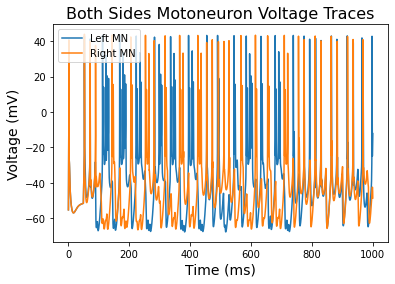

In [15]:
plt.plot(x[100:],mn_voltage_record[0,100:],label='Left MN')
plt.plot(x[100:],mn_voltage_record[1,100:],label='Right MN')
plt.legend()
plt.title('Both Sides Motoneuron Voltage Traces', fontsize='16')
plt.xlabel('Time (ms)',fontsize='14')
plt.ylabel('Voltage (mV)',fontsize='14')
plt.savefig('bothsidesmntrace1000ms')

Text(0, 0.5, 'Voltage (mV)')

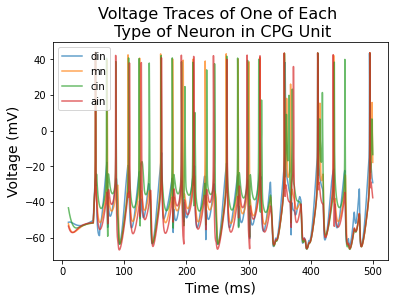

In [811]:
plt.plot(x[1000:],din_voltage_record[1,1000:],label='din',alpha=0.7)
plt.plot(x[1000:],mn_voltage_record[1,1000:],label='mn',alpha=0.7)
plt.plot(x[1000:],cin_voltage_record[1,1000:],label='cin',alpha=0.7)
plt.plot(x[1000:],ain_voltage_record[1,1000:],label='ain',alpha=0.7)
plt.legend()
plt.title('Voltage Traces of One of Each \n Type of Neuron in CPG Unit', fontsize='16')
plt.xlabel('Time (ms)',fontsize='14')
plt.ylabel('Voltage (mV)',fontsize='14')
#plt.savefig('rightsideallneurontraces')

Text(0, 0.5, 'Voltage (mV)')

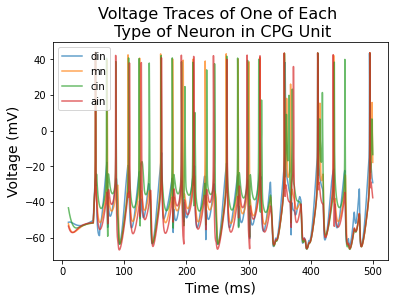

In [812]:
plt.plot(x[1000:],din_voltage_record[1,1000:],label='din',alpha=0.7)
plt.plot(x[1000:],mn_voltage_record[1,1000:],label='mn',alpha=0.7)
plt.plot(x[1000:],cin_voltage_record[1,1000:],label='cin',alpha=0.7)
plt.plot(x[1000:],ain_voltage_record[1,1000:],label='ain',alpha=0.7)
plt.legend()
plt.title('Voltage Traces of One of Each \n Type of Neuron in CPG Unit', fontsize='16')
plt.xlabel('Time (ms)',fontsize='14')
plt.ylabel('Voltage (mV)',fontsize='14')
#plt.savefig('righttsidecpg')

In [784]:
mn_spike_times

[[53.42, 70.48, 130.74, 147.66, 194.07, 205.64000000000001, 222.25],
 [53.42, 71.15, 87.56, 103.94, 129.9, 160.51, 175.93, 221.33, 237.76]]